In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import fasttext
import re
from collections import Counter
from razdel import tokenize
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from scipy import sparse

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
pd.set_option('display.max_rows', 100)

In [4]:
df = pd.read_csv('dataset_intent_detection.csv', header=None)

In [5]:
df.columns = ['class', 'text']

In [6]:
df['text'] = df['text'].map(lambda s: s[2:] if s[0]=='-' else s)

<ipython-input-20-00d89f39f429>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df['class'].unique(), rotation=90);


Text(12, 10, 'This is text')

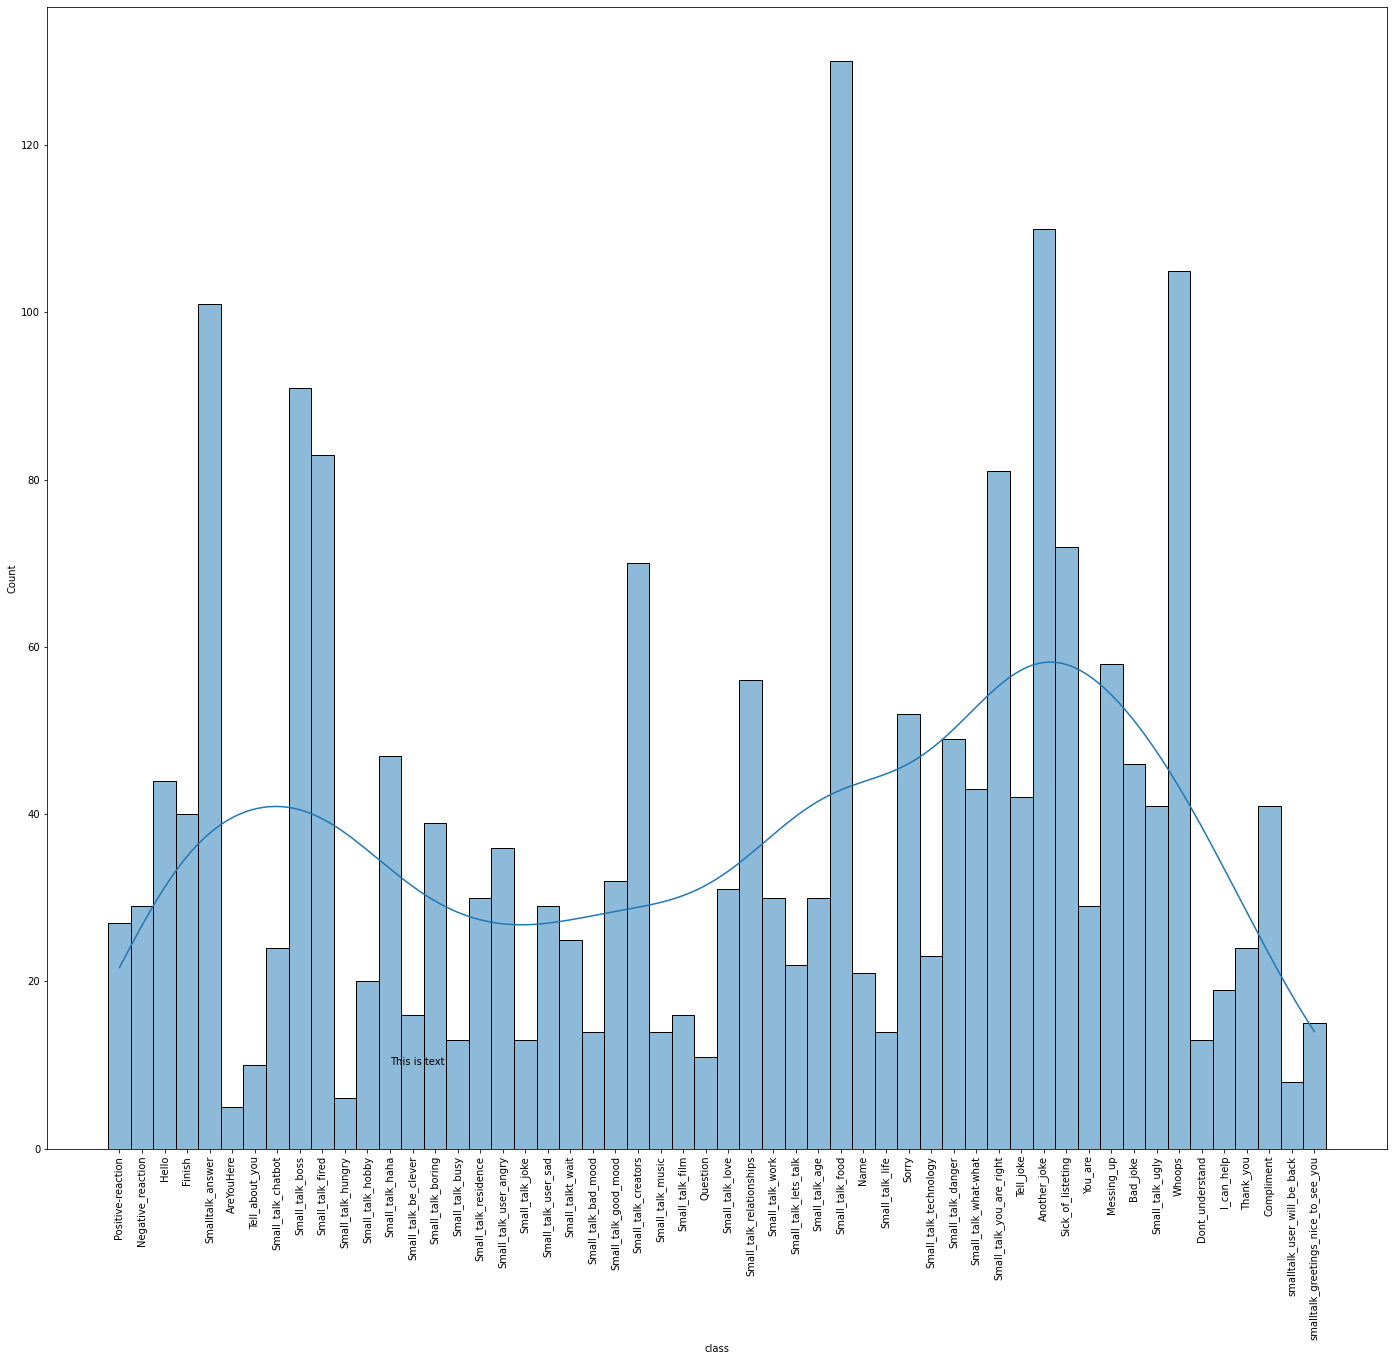

In [20]:
fig, ax = plt.subplots(figsize=(24,21))
chart = sns.histplot(df['class'], kde=True, ax=ax)
ax.set_xticklabels(df['class'].unique(), rotation=90);
# ax.annotate("This is text", (12, 10))

In [6]:
df['text_len'] = df['text'].map(len)

In [228]:
letter_dist = df.groupby('class').agg(lambda s: Counter(''.join(list(map(lambda x: re.sub(' ', '', x), list(s))))))

In [229]:
letter_dist['letter'] = letter_dist['text'].apply(dict.keys)
letter_dist['count'] = letter_dist['text'].apply(dict.values)

In [230]:
letter_dist = letter_dist.drop('text', axis=1).apply(pd.Series.explode)

In [231]:
letter_dist['count'] = letter_dist['count'].astype(int)

In [232]:
letter_dist = letter_dist.reset_index().sort_values(['class', 'count']).set_index('class')

In [233]:
letter_dist[['start']] = letter_dist[['count']].groupby(letter_dist.index).shift(1).fillna(0)

In [234]:
letter_dist[['start']] = letter_dist[['start']].groupby(letter_dist.index).cumsum()

In [235]:
letter_dist = letter_dist.reset_index()

# use double click to get it closer

In [69]:
matplotlib.scale.FuncScale?

In [77]:
def double_scale(x):
    return list(map(lambda s: 2*s, x))

def lower(x):
    return list(map(lambda s: 1, x))

# разобраться со scale

# закодировать каждую букву(символ) цветом

In [35]:
plt.yscale(matplotlib.scale.FuncScale(ax, [lower, double_scale]))

NameError: name 'lower' is not defined

In [18]:
fig, ax = plt.subplots(figsize=(240, 210))
for current_class in letter_dist['class'].unique():
    for letter, cnt, start in letter_dist[letter_dist['class']==current_class][['letter','count','start']].values:
        ax.bar(current_class, cnt, bottom=start)
        ax.text(current_class, start + 0.5, letter, fontsize=12)
ax.set_xticklabels(letter_dist['class'].unique(), rotation=90, fontsize=64)
plt.show()

<ipython-input-18-aec9614159e9>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(letter_dist['class'].unique(), rotation=90, fontsize=64)


# classic features

In [8]:
df['tokenized_text'] = df['text'].apply(lambda s: list(tokenize(s)))

In [9]:
df['sentense_len'] = df['tokenized_text'].map(lambda l: [_.text for _ in l].__len__())

In [10]:
df['words_mean_start_index'] = df['tokenized_text'].map(lambda l: np.mean([_.start for _ in l]))

In [11]:
df['words_mean_end_index'] = df['tokenized_text'].map(lambda l: np.mean([_.stop for _ in l]))

In [12]:
df['words_mean_len'] = df['tokenized_text'].map(lambda l: np.mean([_.stop - _.start for _ in l]))

In [13]:
df['is_question'] = df['text'].map(lambda s: s.find('?')!=-1).astype(int)
df['is_exclamation'] = df['text'].map(lambda s: s.find('!')!=-1).astype(int)
df['is_dot'] = df['text'].map(lambda s: s.find('.')!=-1).astype(int)

In [14]:
df['space_count'] = df['text'].map(lambda s: [_ for _ in s if _==' '].__len__())

#  word encode + features

In [17]:
# correct_symbols = sorted(set(df['text'].map(set).explode().values))[:11]
incorrect_symbols = sorted(set(df['text'].map(set).explode().values))[:12]
incorrect_symbols_regexp = re.sub("'", "", str(incorrect_symbols))
incorrect_symbols_regexp = re.sub(",", "", incorrect_symbols_regexp)
incorrect_symbols_regexp = re.sub(" ", "", incorrect_symbols_regexp)

In [18]:
df['text'] = df['text'].map(lambda s: re.sub(incorrect_symbols_regexp, '', s))

In [19]:
correct_symbols = sorted(set(df['text'].map(set).explode()))

In [20]:
symbols_encode_dict = {symbol:i for i, symbol in enumerate(correct_symbols)}

In [21]:
df['symbols_sum'] = df['text'].map(lambda l: sum([symbols_encode_dict[symbol] for symbol in l])) # sorted first ?

In [22]:
df['symbols_mean'] = df['text'].map(lambda l: np.mean([symbols_encode_dict[symbol] for symbol in l])) # sorted first ?

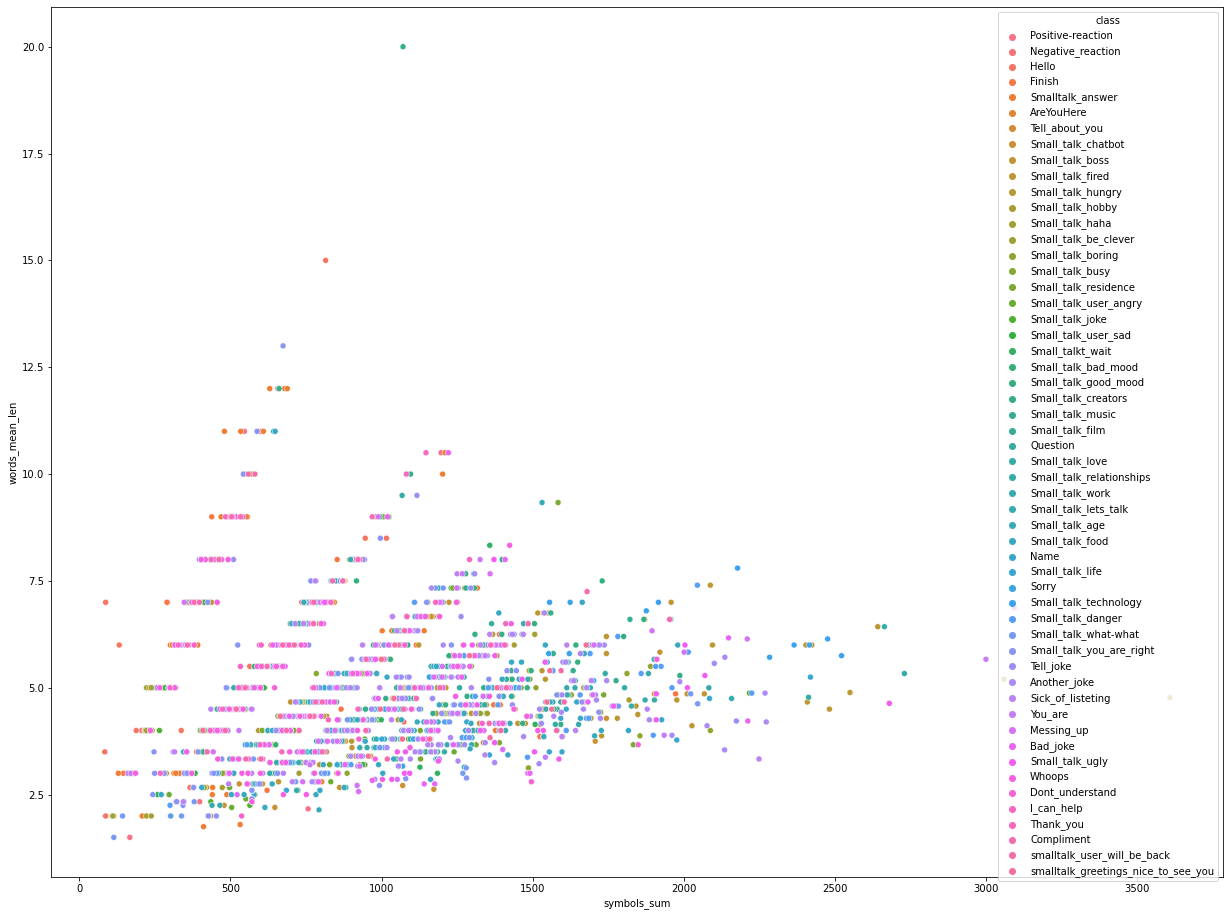

In [250]:
fig,ax = plt.subplots(figsize=(21, 16))
chart = sns.scatterplot(data=df, y='words_mean_len', x='symbols_sum', hue='class')
# ax.set_xticklabels(labels=df['class'].unique(), rotation=90);

# tf-idf

In [342]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
# multilabel_binarizer.fit(df_questions.Tags)
# Y = multilabel_binarizer.transform(df_questions.Tags)

count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(df_questions.Text)

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

# most popular letter

In [31]:
letter_dist.groupby('letter').sum().sort_values('count', ascending=False)[['count']]

,count
letter,
о,3587
т,3101
е,2990
а,2648
н,1897
и,1780
с,1627
к,1338
у,1326


In [32]:
letter_dist.groupby('class').last()

,letter,count,start
class,,,
Another_joke,у,267,2267.0
AreYouHere,т,6,38.0
Bad_joke,т,78,787.0
Compliment,о,67,525.0
Dont_understand,о,24,198.0
Finish,о,61,446.0
Hello,о,56,408.0
I_can_help,о,24,196.0
Messing_up,е,93,981.0


In [48]:
df[df['text'].map(lambda s: (s.find('ау')!=-1) or (s.find('здесь')!=-1))]

,class,text,text_len
4,Positive-reaction,вау,3
241,AreYouHere,ау,2
242,AreYouHere,ау ты тут?,10
243,AreYouHere,здесь ты?,9
244,AreYouHere,здесь или нет,13
419,Small_talk_fired,ты больше не можешь здесь работать,34
562,Small_talk_boring,слишком заурядна,16
658,Small_talk_user_angry,"Бот, я здесь.",13
659,Small_talk_user_angry,"Брат, я здесь.",14
1014,Small_talk_lets_talk,научи меня чему-нибудь,22


# model

> + tf-idf + NaiveBayes (SVM)

In [58]:
tfidf = TfidfVectorizer()

In [59]:
X = tfidf.fit_transform(df['text'])

In [61]:
target_encode_dict = {cls:(num+1) for num, cls in enumerate(df['class'].unique())}

In [62]:
y = df['class'].map(target_encode_dict).values
splitter = StratifiedShuffleSplit(n_splits=5, test_size=0.33, random_state=112)
splitter.get_n_splits(X, y)

5

In [80]:
folds_value_counts = []
folds_value_counts_normalize = []
for num, (train_index, test_index) in zip(range(5), splitter.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    nb = MultinomialNB()
    svc = SVC() # <---- your choice
    linear_svc = LinearSVC()
    sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=6, tol=None)
    lr = LogisticRegression()
    
    print(f"fold: {num}")
    print(set(y_train).__len__(), set(y_test).__len__())
    for classifier in [svc, linear_svc, sgd]:
        clf = OneVsRestClassifier(classifier)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        for average_type in ['micro', 'macro', 'weighted']:
            f1 = f1_score(y_pred, y_test, average=average_type)
            print(f"{average_type}: {f1}   {classifier.__class__.__name__}")
        print()

fold: 0
54 54
micro: 0.5652173913043478   SVC
macro: 0.4961149255654015   SVC
weighted: 0.5750462976943824   SVC

micro: 0.5652173913043478   LinearSVC
macro: 0.4985508782331252   LinearSVC
weighted: 0.5683998136378017   LinearSVC

micro: 0.5594202898550724   SGDClassifier
macro: 0.48717490887734516   SGDClassifier
weighted: 0.568645972840947   SGDClassifier

fold: 1
54 54
micro: 0.5521739130434783   SVC
macro: 0.50448233190663   SVC
weighted: 0.5597302970221725   SVC

micro: 0.5681159420289855   LinearSVC
macro: 0.5248899558630141   LinearSVC
weighted: 0.570019867754988   LinearSVC

micro: 0.5463768115942029   SGDClassifier
macro: 0.49134524576481514   SGDClassifier
weighted: 0.5640020835217332   SGDClassifier

fold: 2
54 54
micro: 0.5739130434782609   SVC
macro: 0.4989070491615595   SVC
weighted: 0.5910855525081609   SVC

micro: 0.5956521739130435   LinearSVC
macro: 0.5406134976948143   LinearSVC
weighted: 0.6005681034971165   LinearSVC

micro: 0.5666666666666667   SGDClassifier
macr

---

> + CountVectorizer + Sequential

In [7]:
count_vec = CountVectorizer()

In [8]:
target_encode_dict = {cls:(num) for num, cls in enumerate(df['class'].unique())}

In [10]:
X = count_vec.fit_transform(df['text'])

In [11]:
y = df['class'].map(target_encode_dict).values
splitter = StratifiedShuffleSplit(n_splits=5, test_size=0.33, random_state=112)
splitter.get_n_splits(X, y)

5

In [50]:
in_dim = X.shape[1]
n_classes = 54
hidden = 500 # подобрано на валидационном датасете

for num, (train_index, test_index) in zip(range(5), splitter.split(X, y)):
    X_train, X_test = torch.Tensor(X[train_index].A), torch.Tensor(X[test_index].A)
    y_train, y_test = torch.LongTensor(y[train_index]), torch.LongTensor(y[test_index])

    print(f"fold: {num}")

    model = nn.Sequential(
        nn.Linear(in_dim, hidden),
        nn.BatchNorm1d(hidden),
        nn.Linear(hidden, n_classes)
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    losses = []

    for epoch in range(10):
        optimizer.zero_grad()
        out = model(X_train)
        loss = criterion(out, y_train)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    for average_type in ['micro', 'macro', 'weighted']:
        pred_label = model(X_test).detach().numpy().argmax(-1)
        true_label = y_test.detach().numpy()
        f1 = f1_score(pred_label, true_label, average=average_type)
        print(f"{average_type}: {f1}")

    print()

fold: 0
micro: 0.5652173913043478
macro: 0.49488352239284483
weighted: 0.5758856707210429

fold: 1
micro: 0.5695652173913044
macro: 0.5121444892939453
weighted: 0.5756130142384309

fold: 2
micro: 0.5869565217391305
macro: 0.5258727462271394
weighted: 0.5987965591462892

fold: 3
micro: 0.5811594202898551
macro: 0.5295687047635778
weighted: 0.5922878820216201

fold: 4
micro: 0.6159420289855072
macro: 0.5363813833350567
weighted: 0.6262593296159297



---

# !!! Stratified

> + bert

In [7]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from tabulate import tabulate
from tqdm import trange
import random

In [8]:
target_encode_dict = {cls:(num) for num, cls in enumerate(df['class'].unique())}

text = df['text'].values
labels = df['class'].map(target_encode_dict).values

In [12]:
tokenizer = BertTokenizer.from_pretrained('cointegrated/rubert-tiny2')

In [14]:
def print_rand_sentence():
    '''Displays the tokens and respective IDs of a random text sample'''
    index = random.randint(0, len(text)-1)
    table = np.array([tokenizer.tokenize(text[index]), 
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text[index]))]).T
    print(tabulate(table,
                   headers = ['Tokens', 'Token IDs'],
                   tablefmt = 'fancy_grid'))

print_rand_sentence()

╒════════════╤═════════════╕
│ Tokens     │   Token IDs │
╞════════════╪═════════════╡
│ тебе       │       30016 │
├────────────┼─────────────┤
│ интересен  │       48214 │
├────────────┼─────────────┤
│ иску       │       35672 │
├────────────┼─────────────┤
│ ##ственный │       13699 │
├────────────┼─────────────┤
│ интеллект  │       31218 │
├────────────┼─────────────┤
│ ?          │          35 │
╘════════════╧═════════════╛


In [15]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
    '''
    Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
      - input_ids: list of token ids
      - token_type_ids: list of token type ids
      - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
    '''
    return tokenizer.encode_plus(
        input_text,
        add_special_tokens = True,
        max_length = 32,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt'
    )


for sample in text:
    encoding_dict = preprocessing(sample, tokenizer)
    token_id.append(encoding_dict['input_ids']) 
    attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/anaconda3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [16]:
def print_rand_sentence_encoding():
    '''Displays tokens, token IDs and attention mask of a random text sample'''
    index = random.randint(0, len(text) - 1)
    tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
    token_ids = [i.numpy() for i in token_id[index]]
    attention = [i.numpy() for i in attention_masks[index]]
  
    table = np.array([tokens, token_ids, attention]).T
    print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

╒══════════╤═════════════╤══════════════════╕
│ Tokens   │   Token IDs │   Attention Mask │
╞══════════╪═════════════╪══════════════════╡
│ [CLS]    │           2 │                1 │
├──────────┼─────────────┼──────────────────┤
│ и        │         320 │                1 │
├──────────┼─────────────┼──────────────────┤
│ мне      │       20284 │                1 │
├──────────┼─────────────┼──────────────────┤
│ тоже     │       19091 │                1 │
├──────────┼─────────────┼──────────────────┤
│ [SEP]    │           3 │                1 │
├──────────┼─────────────┼──────────────────┤
│ [PAD]    │           0 │                0 │
├──────────┼─────────────┼──────────────────┤
│ [PAD]    │           0 │                0 │
├──────────┼─────────────┼──────────────────┤
│ [PAD]    │           0 │                0 │
├──────────┼─────────────┼──────────────────┤
│ [PAD]    │           0 │                0 │
├──────────┼─────────────┼──────────────────┤
│ [PAD]    │           0 │        

In [17]:
val_ratio = 0.2
# Recommended batch size: 16, 32. See: https://arxiv.org/pdf/1810.04805.pdf
batch_size = 16

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

In [30]:
def b_tp(preds, labels):
    '''Returns True Positives (TP): count of correct predictions of actual class 1'''
    return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
    '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
    return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
    '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
    return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
    '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
    return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
    '''
    Returns the following metrics:
      - accuracy    = (TP + TN) / N
      - precision   = TP / (TP + FP)
      - recall      = TP / (TP + FN)
      - specificity = TN / (TN + FP)
    '''
    preds = np.argmax(preds, axis = 1).flatten()
    labels = labels.flatten()
    return f1_score(preds, labels, average='weighted')
#     tp = b_tp(preds, labels)
#     tn = b_tn(preds, labels)
#     fp = b_fp(preds, labels)
#     fn = b_fn(preds, labels)
#     b_accuracy = (tp + tn) / len(labels)
#     b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
#     b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
#     b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
#     return b_accuracy, b_precision, b_recall, b_specificity

In [34]:
# Load the BertForSequenceClassification model
# model = BertForSequenceClassification.from_pretrained(
#     'bert-base-uncased',
#     num_labels = 2,
#     output_attentions = False,
#     output_hidden_states = False,
# )

model = BertForSequenceClassification.from_pretrained(
    'cointegrated/rubert-tiny2',
    num_labels = 54,
    output_attentions = False,
    output_hidden_states = False,
)

# Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5. See: https://arxiv.org/pdf/1810.04805.pdf
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 3e-5,
                              eps = 1e-08
                              )

# Run on GPU
# model.cuda()

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not 

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Recommended number of epochs: 2, 3, 4. See: https://arxiv.org/pdf/1810.04805.pdf
epochs = 20

for _ in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        f1 = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
#         if b_precision != 'nan': val_precision.append(b_precision)
#         # Update recall only when (tp + fn) !=0; ignore nan
#         if b_recall != 'nan': val_recall.append(b_recall)
#         # Update specificity only when (tn + fp) !=0; ignore nan
#         if b_specificity != 'nan': val_specificity.append(b_specificity)
    print(f1)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')

Epoch:  12%|█▎        | 1/8 [00:33<03:57, 34.00s/it]

0.5

	 - Train loss: 1.6947
	 - Validation Accuracy: 0.0000
	 - Validation Precision: NaN
	 - Validation Recall: NaN
	 - Validation Specificity: NaN


Epoch:  25%|██▌       | 2/8 [01:07<03:22, 33.70s/it]

0.5

	 - Train loss: 1.5266
	 - Validation Accuracy: 0.0000
	 - Validation Precision: NaN
	 - Validation Recall: NaN
	 - Validation Specificity: NaN


Epoch:  38%|███▊      | 3/8 [01:40<02:47, 33.54s/it]

0.5

	 - Train loss: 1.3799
	 - Validation Accuracy: 0.0000
	 - Validation Precision: NaN
	 - Validation Recall: NaN
	 - Validation Specificity: NaN


Epoch:  50%|█████     | 4/8 [02:14<02:13, 33.43s/it]

0.5

	 - Train loss: 1.2473
	 - Validation Accuracy: 0.0000
	 - Validation Precision: NaN
	 - Validation Recall: NaN
	 - Validation Specificity: NaN


Epoch:  62%|██████▎   | 5/8 [02:47<01:40, 33.35s/it]

0.5

	 - Train loss: 1.1262
	 - Validation Accuracy: 0.0000
	 - Validation Precision: NaN
	 - Validation Recall: NaN
	 - Validation Specificity: NaN


Epoch:  75%|███████▌  | 6/8 [03:20<01:06, 33.40s/it]

0.5

	 - Train loss: 1.0261
	 - Validation Accuracy: 0.0000
	 - Validation Precision: NaN
	 - Validation Recall: NaN
	 - Validation Specificity: NaN


Epoch:  88%|████████▊ | 7/8 [03:54<00:33, 33.53s/it]

0.5

	 - Train loss: 0.9285
	 - Validation Accuracy: 0.0000
	 - Validation Precision: NaN
	 - Validation Recall: NaN
	 - Validation Specificity: NaN


Epoch: 100%|██████████| 8/8 [04:27<00:00, 33.50s/it]

0.5

	 - Train loss: 0.8423
	 - Validation Accuracy: 0.0000
	 - Validation Precision: NaN
	 - Validation Recall: NaN
	 - Validation Specificity: NaN


In [41]:
df_copy = df.copy()

In [43]:
df_copy['class_enc'] = df_copy['class'].map(target_encode_dict)

In [113]:
preds = []
for sent, lbl in df_copy[['text', 'class_enc']].values[val_idx]:
    new_sentence = sent

    # We need Token IDs and Attention Mask for inference on the new sentence
    test_ids = []
    test_attention_mask = []

    # Apply the tokenizer
    encoding = preprocessing(new_sentence, tokenizer)

    # Extract IDs and Attention Mask
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)

    with torch.no_grad():
        output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

    preds.append([np.argmax(output.logits.cpu().numpy()).flatten().item(), lbl])

/opt/anaconda3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [114]:
f1_score(np.array(preds)[:, 0], np.array(preds)[:, 1], average='weighted')

0.7392710702133117

---

In [81]:
!pip install fasttext > /dev/null

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 KB 648.7 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.0-py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp38-cp38-macosx_10_14_x86_64.whl size=348943 sha256=1971501219b1a3f7e6d3ff31e673bd152c5b3e22dd86346e6adee3f343a1a71e
  Stored in directory: /Users/dmitryilikbaev/Library/Caches/pip/wheels/93/61/2a/c54711a91c418ba06ba195b1d78ff24fcaad8592f2a694ac94
Successfully built fasttext
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [251]:
from sklearn.model_selection import StratifiedShuffleSplit

In [262]:
target_encode_dict = {cls:(num+1) for num, cls in enumerate(df['class'].unique())}

In [283]:
X = df.drop(['class', 'text','tokenized_text'], axis=1)
y = df['class'].map(target_encode_dict)
splitter = StratifiedShuffleSplit(n_splits=5, test_size=0.33, random_state=112)
splitter.get_n_splits(X, y)

5

In [284]:
folds_value_counts = []
folds_value_counts_normalize = []
for train_index, test_index in splitter.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
#     folds_value_counts.append([y_train.sort_values().value_counts(), y_test.sort_values().value_counts()])
#     folds_value_counts_normalize.append([y_train.sort_values().value_counts(normalize=True), y_test.sort_values().value_counts(normalize=True)])

In [335]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss
from sklearn.metrics import f1_score

In [333]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred.iloc[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/float(len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)))
    print("Hamming score: {}".format(hamming_score(y_pred, y_test)))
    print("---")    

In [341]:
nb_clf = MultinomialNB()
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=6, tol=None)
lr = LogisticRegression()
mn = MultinomialNB()

for classifier in [nb_clf, sgd, lr, mn]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
#     print_score(y_pred, classifier)
    for average_type in ['micro', 'macro', 'weighted']:
        f1 = f1_score(y_pred, y_test, average=average_type)
        print(f"{average_type}: {f1}   {classifier.__class__.__name__}")

micro: 0.09420289855072464   MultinomialNB
macro: 0.036755441482651835   MultinomialNB
weighted: 0.12732018483693153   MultinomialNB
micro: 0.034782608695652174   SGDClassifier
macro: 0.0012466884837151317   SGDClassifier
weighted: 0.06722361119580461   SGDClassifier


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

micro: 0.13768115942028986   LogisticRegression
macro: 0.03981689266032849   LogisticRegression
weighted: 0.1955073479543188   LogisticRegression
micro: 0.09420289855072464   MultinomialNB
macro: 0.036755441482651835   MultinomialNB
weighted: 0.12732018483693153   MultinomialNB
